In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import torch.optim as optim
import os

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [3]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_transformer = transforms.Compose([
    transforms.Resize([128,128]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomGrayscale(p=0.5),
    transforms.ColorJitter(saturation=0.5),
    transforms.ToTensor(),
    transforms.Normalize(*stats, inplace=True)
])

valid_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats, inplace=True)
])

In [4]:
train_dataset = ImageFolder('./Covid19-dataset/train', transform=train_transformer)
test_dataset = ImageFolder('./Covid19-dataset/test', transform=valid_transformer)
labels = train_dataset.classes
labels

['Covid', 'Normal', 'Viral Pneumonia']

In [5]:
def denormalize(image, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return image * stds + means

  0%|          | 0/25 [00:00<?, ?it/s]

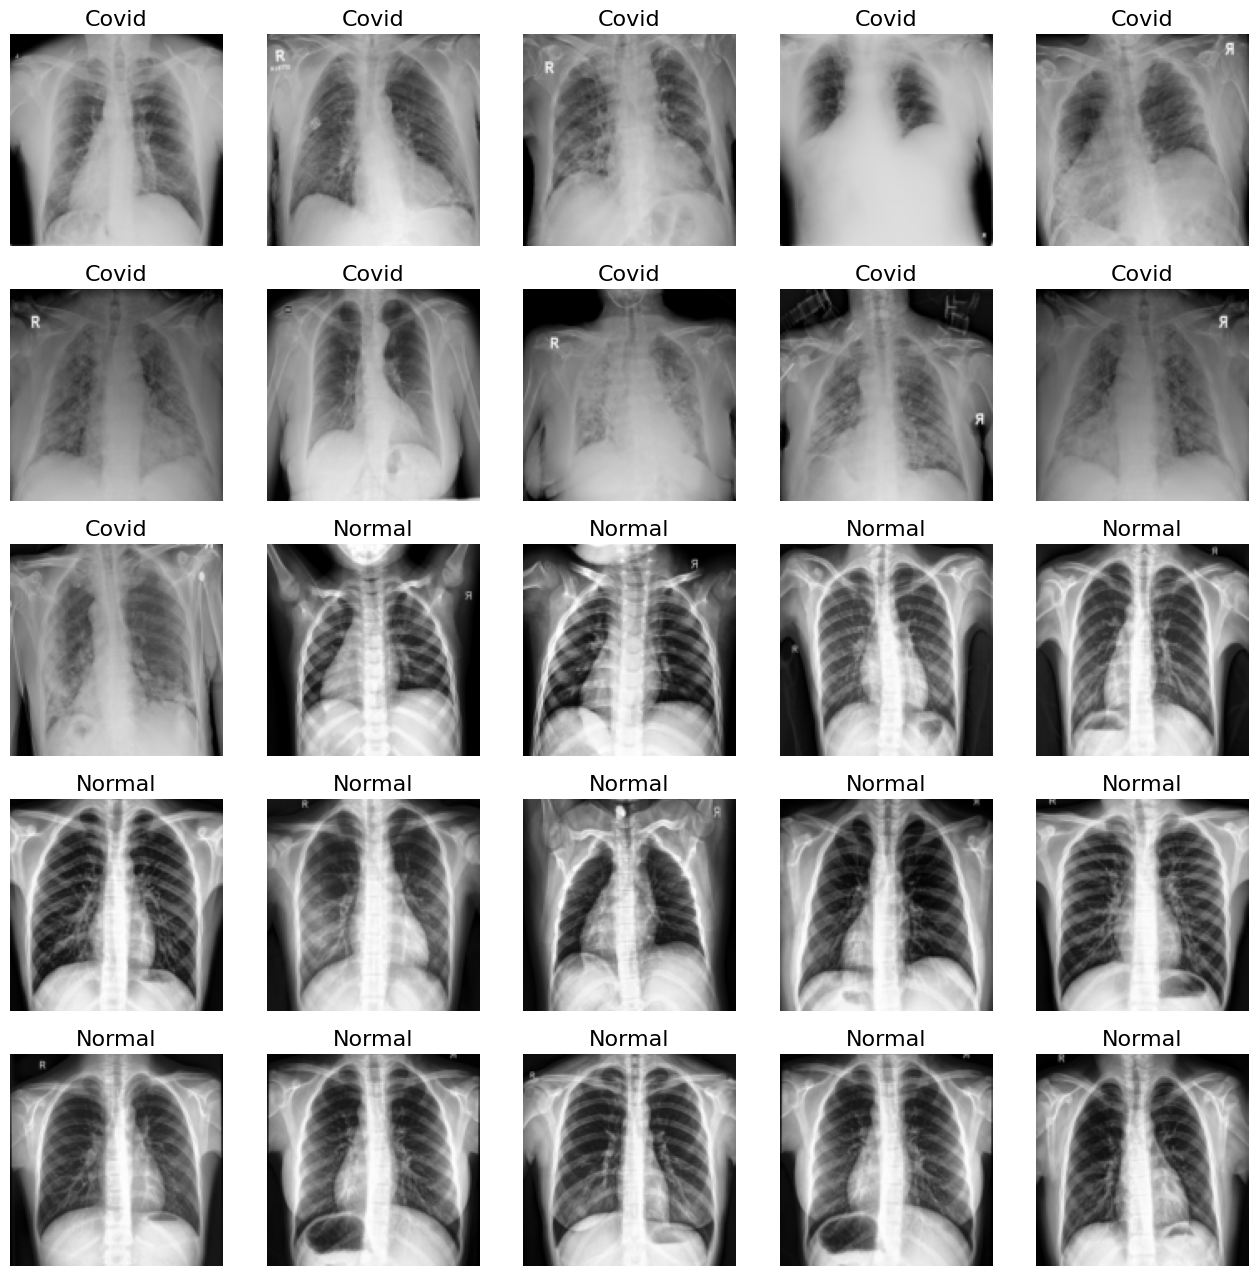

In [6]:
# Show some dataset
plt.figure(figsize=(16,16))
for i in tqdm(range(25)):
    images, labs = train_dataset[i+100]
    images = denormalize(images, *stats)
    # images = images.cpu().numpy()
    images = images.permute(0,2,3,1)
    
    ax = plt.subplot(5,5,i+1)
    
    ax.set_title(labels[labs], fontsize=16)
    plt.imshow(images[0].clamp(0,1))
    plt.axis("off")

In [7]:
image_dataset = {x: ImageFolder(os.path.join('Covid19-dataset', x), transform=train_transformer if x=='train' else valid_transformer)
                    for x in ['train','test']}
dataloader = {x: DataLoader(image_dataset[x], batch_size=40, shuffle=True, num_workers=0)
                 for x in ['train', 'test']}
dataset_sizes = {x: len(image_dataset[x]) for x in ['train', 'test']}

for images, labs in dataloader['train']:
    print(f"Image Data Shape: {images.shape}")
    print(f"Labels Shape: {labs.shape}")
    break

Image Data Shape: torch.Size([40, 3, 128, 128])
Labels Shape: torch.Size([40])


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256,256, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.batchnorm4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2,2)
        self.drop = nn.Dropout(0.2)
        self.fc1  = nn.Linear(256*4*4, 1024)
        self.fc2  = nn.Linear(1024, 512)
        self.fc3  = nn.Linear(512,3)
        self.batchnorm5 = nn.BatchNorm1d(1024)
        self.batchnorm6 = nn.BatchNorm1d(512)
        
    def forward(self,x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))
        x = self.pool(F.relu(self.batchnorm4(self.conv4(x))))
        x = self.pool(F.relu(self.batchnorm4(self.conv5(x))))
        x = torch.flatten(x, 1)
        x = self.drop(x)
        x = F.relu(self.batchnorm5(self.fc1(x)))
        x = F.relu(self.batchnorm6(self.fc2(x)))
        x = self.fc3(x)
        return x
    
net = Net()

In [9]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [10]:
def train_model(model, criterion, optimizer, patience, n_epochs, dataloader):
    
    #track the losses
    train_losses, valid_losses = [], []
    avg_train_losses, avg_valid_losses = [], []
    train_acc, valid_acc = 0, 0
    avg_train_acc, avg_valid_acc = [], []

    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs+1):
        for phase in ['train', 'test']:
            if phase=='train':
                model.train()
            else:
                model.eval()
                
            train_correct, valid_correct = 0.0, 0.0
            
            for inputs, label in dataloader[phase]:
                inputs, label = inputs.to(device), label.to(device)
                
                optimizer.zero_grad()
                
                outputs = model(inputs)
                _, preds = torch.max(outputs,1)
                loss = criterion(outputs, label)
                
                if phase=='train':
                    loss.backward()
                    optimizer.step()
                    train_losses.append(loss.item())
                    train_acc += torch.sum(preds==label.data)
                    
                else:
                    valid_losses.append(loss.item())
                    valid_acc += torch.sum(preds==label.data)

        train_acc = float(train_acc)/dataset_sizes['train']
        valid_acc = float(valid_acc)/dataset_sizes['test']
        avg_train_acc.append(train_acc)
        avg_valid_acc.append(valid_acc)

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(n_epochs))

        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f} ' +
                     f'train_accuracy: {train_acc:.5f} ' +
                     f'valid_accuracy: {valid_acc:.5f}')

        print(print_msg)
        
        train_losses, valid_losses = [], []
        train_acc, valid_acc = 0, 0
        
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping... ")
            break
    
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    return model, avg_train_losses, avg_valid_losses, avg_train_acc, avg_valid_acc               

In [11]:
net.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=102

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [13]:
model, train_loss, valid_loss, train_acc, valid_acc = train_model(net, 
                                                                  criterion=criterion, 
                                                                  optimizer=optimizer, 
                                                                  patience=15, 
                                                                  n_epochs=100, 
                                                                  dataloader=dataloader)

RuntimeError: stack expects each tensor to be equal size, but got [3, 872, 1280] at entry 0 and [3, 891, 880] at entry 1

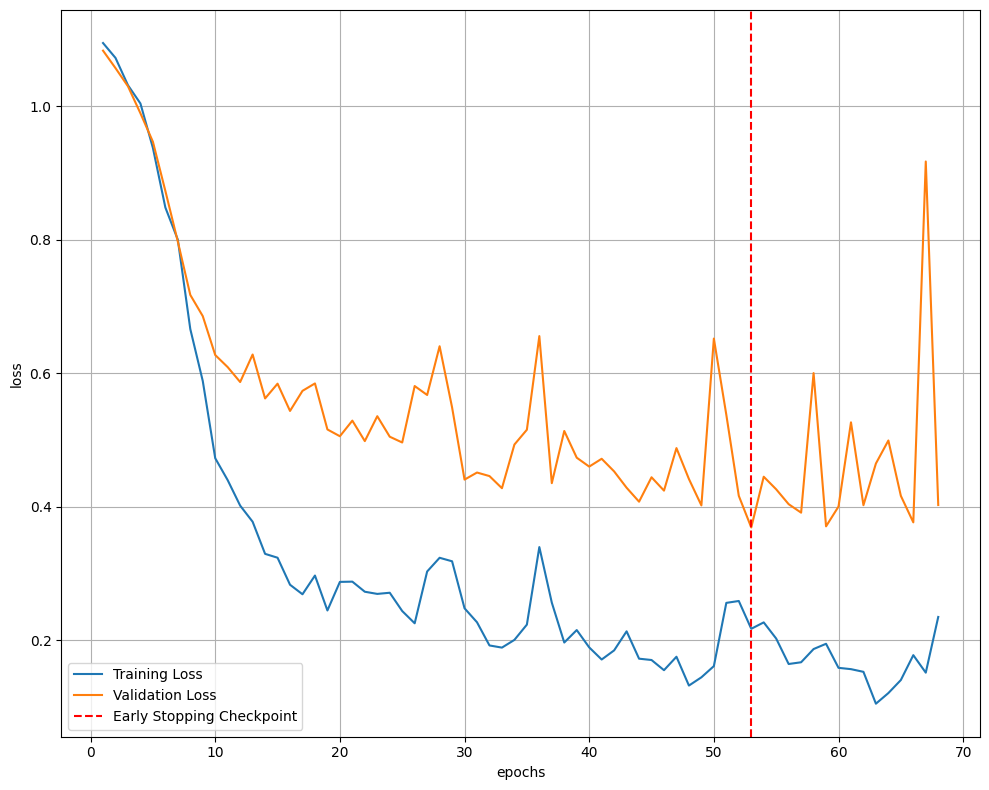

In [18]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# fig.savefig('loss_plot.png', bbox_inches='tight')

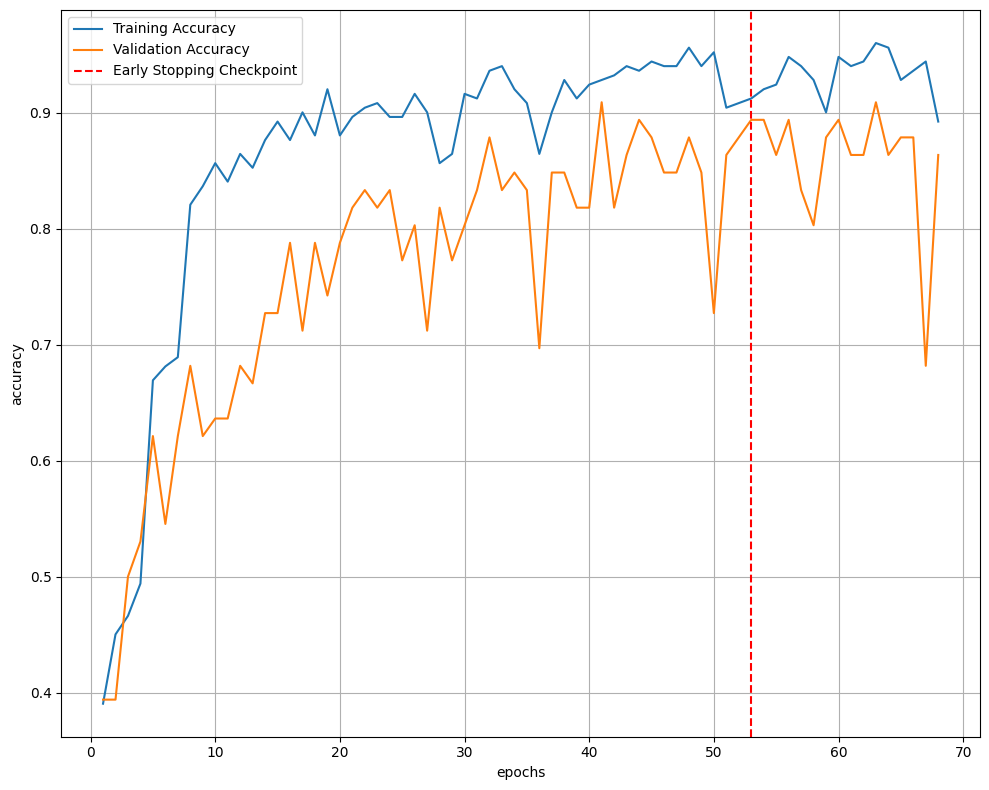

In [19]:
# visualize the accuracy as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_acc)+1),train_acc, label='Training Accuracy')
plt.plot(range(1,len(valid_acc)+1),valid_acc,label='Validation Accuracy')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# fig.savefig('loss_plot.png', bbox_inches='tight')

In [21]:
test_loss = 0.0
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))
class_correct_total = list(0. for i in range(3))
total_all = list(0. for i in range(3))

model.eval() # prep model for evaluation

for data, target in dataloader['test']:

    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data.to(device))
    # calculate the loss
    loss = criterion(output, target.to(device))
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred).to(device)))
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    for i in range(3):
        class_correct_total[i] += class_correct[i]
        total_all[i] += class_total[i]
# calculate and print avg test loss
test_loss = test_loss/len(dataloader['test'].dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(3):
    if class_total[i] > 0:
        print(f'Test Accuracy of {labels[i]}: {100*class_correct_total[i]/total_all[i]:.2f}% ({int(np.sum(class_correct_total[i]))}/{int(np.sum(total_all[i]))})')
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (labels[i]))

print(f'\nTest Accuracy (Overall): {100.*np.sum(class_correct_total)/np.sum(total_all):2f}% ({int(np.sum(class_correct_total))}/{int(np.sum(total_all))})')

Test Loss: 0.403136

Test Accuracy of Covid: 93.18% (41/44)
Test Accuracy of Normal: 83.87% (26/31)
Test Accuracy of Viral Pneumonia: 90.32% (28/31)

Test Accuracy (Overall): 89.622642% (95/106)


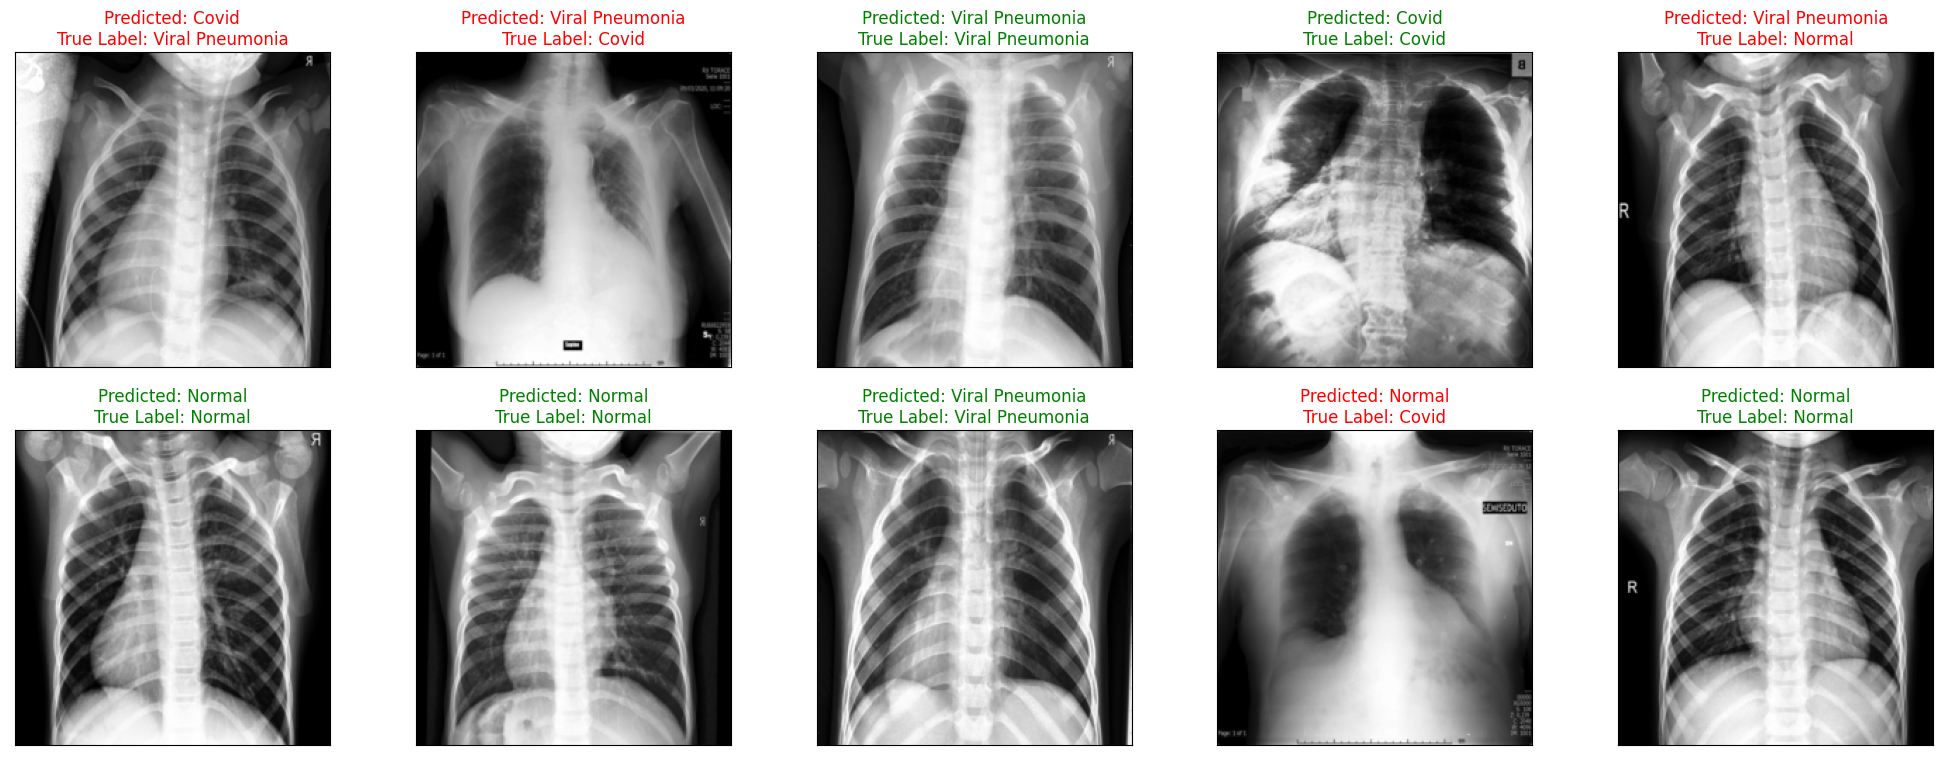

In [23]:
# obtain one batch of test images
dataiter = iter(dataloader['test'])
images, labs = next(dataiter)

# get sample outputs
output = model(images.to(device))
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 9))
for idx in np.arange(10):
    imag = images[idx].transpose(1,2,0)
    ax = fig.add_subplot(2, int(10/2), idx+1, xticks=[], yticks=[])
    ax.imshow(imag, cmap='gray')
    ax.set_title(f"Predicted: {labels[preds[idx].item()]}\nTrue Label: {labels[labs[idx].item()]}",
                 color=("green" if preds[idx]==labs[idx] else "red"))